In [4]:
import sys,os

# Path to Resources
RES_PATH = './bunny/data_rough_aligned'
COR_PATH = './bunny/correspondences'

# Checking if the path is found locally
if not os.path.exists(RES_PATH):
    print( 'cannot find mesh resources dir, please update RES_PATH')
    exit(1)
else:
    print('found resources')

# Loading libraries for basic geometry processing
import trimesh
import numpy as np
from sklearn.neighbors import KDTree

found resources


### Registration with multiple scans

Given multiple scans M1,M2,...M6 align all of them to a common global coordinate frame.

In [5]:
# Load point cloud models M1 ~ M6
mesh_fp1 = os.path.join(RES_PATH,'bun000.ply')
assert os.path.exists(mesh_fp1), 'Cannot find:' + mesh_fp1
M1 = trimesh.load(mesh_fp1)
print('M1 shape of Vertices:', M1.vertices.shape)

mesh_fp2 = os.path.join(RES_PATH,'bun090.ply')
assert os.path.exists(mesh_fp2), 'Cannot find:' + mesh_fp2
M2 = trimesh.load(mesh_fp2)
print('M2 shape of Vertices:', M2.vertices.shape)

mesh_fp3 = os.path.join(RES_PATH,'bun180.ply')
assert os.path.exists(mesh_fp3), 'Cannot find:' + mesh_fp3
M3 = trimesh.load(mesh_fp3)
print('M3 shape of Vertices:', M3.vertices.shape)

mesh_fp4 = os.path.join(RES_PATH,'bun270.ply')
assert os.path.exists(mesh_fp4), 'Cannot find:' + mesh_fp4
M4 = trimesh.load(mesh_fp4)
print('M4 shape of Vertices:', M4.vertices.shape)

mesh_fp5 = os.path.join(RES_PATH,'top2.ply')
assert os.path.exists(mesh_fp5), 'Cannot find:' + mesh_fp5
M5 = trimesh.load(mesh_fp5)
print('M5 shape of Vertices:', M5.vertices.shape)

mesh_fp6 = os.path.join(RES_PATH,'chin.ply')
assert os.path.exists(mesh_fp6), 'Cannot find:' + mesh_fp6
M6 = trimesh.load(mesh_fp6)
print('M6 shape of Vertices:', M6.vertices.shape)

# Create a list to store models to be registered
models = [M1, M2, M3, M4, M5, M6]
print(models)

M1 shape of Vertices: (40256, 3)
M2 shape of Vertices: (30373, 3)
M3 shape of Vertices: (40247, 3)
M4 shape of Vertices: (31697, 3)
M5 shape of Vertices: (38297, 3)
M6 shape of Vertices: (37737, 3)
[<trimesh.PointCloud(vertices.shape=(40256, 3), name=`bun000.ply`)>, <trimesh.Trimesh(vertices.shape=(30373, 3), faces.shape=(59629, 3), name=`bun090.ply`)>, <trimesh.Trimesh(vertices.shape=(40247, 3), faces.shape=(79284, 3), name=`bun180.ply`)>, <trimesh.Trimesh(vertices.shape=(31697, 3), faces.shape=(62335, 3), name=`bun270.ply`)>, <trimesh.Trimesh(vertices.shape=(38297, 3), faces.shape=(75530, 3), name=`top2.ply`)>, <trimesh.Trimesh(vertices.shape=(37737, 3), faces.shape=(74369, 3), name=`chin.ply`)>]


In [7]:
def align_multiple_scans(scans, max_iterations=11, tolerance=1e-6):
    """
    Align multiple scans to a common global coordinate frame.

    Args:
    - scans: a list of numpy arrays representing the vertices of each scan (shape: [N_scan, Nx3])
    - max_iterations: maximum number of iterations for ICP algorithm
    - tolerance: tolerance for convergence

    Returns:
    - aligned_scans: a list of aligned scans (as trimesh.pointcloud.PointCloud objects)
    """

    # Initialize list to store aligned scans
    aligned_scans = []
    aligned_scans.append(scans[0])

    for i, scan in enumerate(scans[1:], start=1):
        print(f'Processing model M{i+1}...')
        # Copy the vertices to avoid modifying the original data
        scan_vertices = scan.vertices.copy()

        # Set reference scan as the previous one
        reference_scan = aligned_scans[i-1].vertices.copy()

        # Initialize rotation matrix R and translation vector t
        R = np.eye(3)
        t = np.zeros((3, 1))

        # Perform ICP to align the current scan to the reference scan
        for iteration in range(1, max_iterations+1):
            # Find the nearest neighbors between the current scan and the reference scan
            tree = KDTree(reference_scan)
            _, indices = tree.query(scan_vertices)

            # Extract corresponding points from the reference scan and the current scan
            P = reference_scan[indices].squeeze()
            Q = scan_vertices

            # Compute the centroid of the matched points
            centroid_P = np.mean(P, axis=0, keepdims=True)  #(1, 3)
            centroid_Q = np.mean(Q, axis=0, keepdims=True)  #(1, 3)

            # Compute the cross-covariance matrix
            A = (Q - centroid_Q).T @ (P - centroid_P)   #(3, n) x (n, 3)

            # Use Singular Value Decomposition (SVD) to compute the optimal rotation matrix R
            U, _, Vt = np.linalg.svd(A)
            R = Vt.T @ np.diag([1, 1, np.linalg.det(Vt.T @ U.T)]) @U.T

            # Compute the optimal translation vector t
            t = centroid_P.T - R @ centroid_Q.T

            # Apply transformation to the current scan for the next iteration
            scan_vertices = (R @ scan_vertices.T + t).T

            # Check convergence
            if np.linalg.norm(t) < tolerance:
                print('Converge at iteration', iteration)
                break

        if iteration == max_iterations:
            print(iteration, 'iterations complete.')

        # Store the aligned scan
        aligned_scan = trimesh.points.PointCloud(scan_vertices)
        aligned_scans.append(aligned_scan)

    return aligned_scans

In [8]:
aligned_scans = align_multiple_scans(models)

for i, aligned_scan in enumerate(aligned_scans):
    directory = './results/cw/method1/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = f"registered_M{i+1}.ply"
    filepath = os.path.join(directory, filename)
    aligned_scan.export(filepath)

Processing model M2...


11 iterations complete.
Processing model M3...
11 iterations complete.
Processing model M4...
11 iterations complete.
Processing model M5...
11 iterations complete.
Processing model M6...
11 iterations complete.


In [9]:
def align_multiple_scans_2(scans, max_iterations=11, tolerance=1e-6):
    """
    Align multiple scans to a common global coordinate frame.

    Args:
    - scans: a list of numpy arrays representing the vertices of each scan (shape: [N_scan, Nx3])
    - max_iterations: maximum number of iterations for ICP algorithm
    - tolerance: tolerance for convergence

    Returns:
    - aligned_scans: a list of aligned scans (as trimesh.pointcloud.PointCloud objects)
    """

    # Initialize list to store aligned scans
    aligned_scans = []
    aligned_scans.append(scans[0])

    for i, scan in enumerate(scans[1:], start=1):
        print(f'Processing model M{i+1}...')
        # Copy the vertices to avoid modifying the original data
        scan_vertices = scan.vertices.copy()

        # Set reference scan as all the other scans
        other_scans = scans[:i] + scans[i+1:]
        reference_scan = np.concatenate([s.vertices.copy() for s in other_scans])

        # Initialize rotation matrix R and translation vector t
        R = np.eye(3)
        t = np.zeros((3, 1))

        # Perform ICP to align the current scan to the reference scan
        for iteration in range(1, max_iterations+1):
            # Find the nearest neighbors between the current scan and the reference scan
            tree = KDTree(reference_scan)
            _, indices = tree.query(scan_vertices)

            # Extract corresponding points from the reference scan and the current scan
            P = reference_scan[indices].squeeze()
            Q = scan_vertices

            # Compute the centroid of the matched points
            centroid_P = np.mean(P, axis=0, keepdims=True)  #(1, 3)
            centroid_Q = np.mean(Q, axis=0, keepdims=True)  #(1, 3)

            # Compute the cross-covariance matrix
            A = (Q - centroid_Q).T @ (P - centroid_P)   #(3, n) x (n, 3)

            # Use Singular Value Decomposition (SVD) to compute the optimal rotation matrix R
            U, _, Vt = np.linalg.svd(A)
            R = Vt.T @ np.diag([1, 1, np.linalg.det(Vt.T @ U.T)]) @ U.T

            # Compute the optimal translation vector t
            t = centroid_P.T - R @ centroid_Q.T

            # Apply transformation to the current scan for the next iteration
            scan_vertices = (R @ scan_vertices.T + t).T

            # Check convergence
            if np.linalg.norm(t) < tolerance:
                print('Converge at iteration', iteration)
                break

        if iteration == max_iterations:
            print(iteration, 'iterations complete.')

        # Store the aligned scan
        aligned_scan = trimesh.points.PointCloud(scan_vertices)
        aligned_scans.append(aligned_scan)

    return aligned_scans

In [10]:
aligned_scans = align_multiple_scans_2(models)

for i, aligned_scan in enumerate(aligned_scans):
    directory = './results/cw/method2/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = f"registered_M{i+1}.ply"
    filepath = os.path.join(directory, filename)
    aligned_scan.export(filepath)

Processing model M2...
11 iterations complete.
Processing model M3...
11 iterations complete.
Processing model M4...
11 iterations complete.
Processing model M5...
11 iterations complete.
Processing model M6...
11 iterations complete.


## Simultaneous Multiview Registration

In [49]:
import sys,os

# Path to Resources
RES_PATH = './bunny/data_rough_aligned'
COR_PATH = './bunny/correspondences'

# Checking if the path is found locally
if not os.path.exists(RES_PATH):
    print( 'cannot find mesh resources dir, please update RES_PATH')
    exit(1)
else:
    print('found resources')

# Loading libraries for basic geometry processing
import trimesh
import numpy as np
from sklearn.neighbors import KDTree

found resources


In [50]:
num_views = 6  # (M) There are 6 views in the example (V1 to V6)
num_correspondences = 12  # (P) There are 12 correspondence sets (S1 to S12)

In [51]:
# Load multi-views point cloud models M1 ~ M6
mesh_fp1 = os.path.join(RES_PATH,'bun000.ply')
assert os.path.exists(mesh_fp1), 'Cannot find:' + mesh_fp1
M1 = trimesh.load(mesh_fp1)
print('M1 shape of Vertices:', M1.vertices.shape)

mesh_fp2 = os.path.join(RES_PATH,'bun090.ply')
assert os.path.exists(mesh_fp2), 'Cannot find:' + mesh_fp2
M2 = trimesh.load(mesh_fp2)
print('M2 shape of Vertices:', M2.vertices.shape)

mesh_fp3 = os.path.join(RES_PATH,'bun180.ply')
assert os.path.exists(mesh_fp3), 'Cannot find:' + mesh_fp3
M3 = trimesh.load(mesh_fp3)
print('M3 shape of Vertices:', M3.vertices.shape)

mesh_fp4 = os.path.join(RES_PATH,'bun270.ply')
assert os.path.exists(mesh_fp4), 'Cannot find:' + mesh_fp4
M4 = trimesh.load(mesh_fp4)
print('M4 shape of Vertices:', M4.vertices.shape)

mesh_fp5 = os.path.join(RES_PATH,'top2.ply')
assert os.path.exists(mesh_fp5), 'Cannot find:' + mesh_fp5
M5 = trimesh.load(mesh_fp5)
print('M5 shape of Vertices:', M5.vertices.shape)

mesh_fp6 = os.path.join(RES_PATH,'chin.ply')
assert os.path.exists(mesh_fp6), 'Cannot find:' + mesh_fp6
M6 = trimesh.load(mesh_fp6)
print('M6 shape of Vertices:', M6.vertices.shape)

# Create a list to store models to be registered
models = [M1.vertices.copy(), M2.vertices.copy(), M3.vertices.copy(), M4.vertices.copy(), M5.vertices.copy(), M6.vertices.copy()]

M1 shape of Vertices: (40256, 3)
M2 shape of Vertices: (30373, 3)
M3 shape of Vertices: (40247, 3)
M4 shape of Vertices: (31697, 3)
M5 shape of Vertices: (38297, 3)
M6 shape of Vertices: (37737, 3)


In [52]:
import numpy as np
from sklearn.neighbors import KDTree
import trimesh
import os

def compute_threshold(distances):
    # Calculate the 75th and 25th percentiles of the distances
    q75, q25 = np.percentile(distances, [75 ,25])
    iqr = q75 - q25  # Interquartile range
    return q75 + 1.5 * iqr  # Calculate the threshold using IQR

def find_nearest_pts(source_pts, target_pts, threshold, filter=True):
    # Build a KDTree for each point cloud
    kdtree_src = KDTree(source_pts)    
    # Query the tree for nearest points to each point in the other point cloud
    d_src, id_src = kdtree_src.query(target_pts, return_distance=True)     
    # Gather nearest points based on the indices returned by KDTree
    nearest_src = np.squeeze(source_pts[id_src])
    

    if filter == True:
        valid_id = d_src.flatten() < threshold        
        nearest_src = nearest_src[valid_id]
        nearest_src = np.unique(nearest_src, axis=0)

    nearest_src = np.unique(nearest_src, axis=0)

    kdtree_target = KDTree(target_pts)
    d_target, id_target = kdtree_target.query(nearest_src, return_distance=True)
    nearest_target = np.squeeze(target_pts[id_target])     
                            
    return nearest_src, nearest_target

def process_selected_dataset_pairs(point_sets, pairs_to_process, save_pairs=True, filter=True):
    # Ensure the specified directory exists; if not, create it
    # if not os.path.exists(folder_path):
    #     os.makedirs(folder_path)

    X = []
    Y = []
    for (i, j) in pairs_to_process:
        
        # Create KDTree for the j-th point set
        tree = KDTree(point_sets[j]) #source pts
        # Find distances to all points in the i-th point set
        distances, _ = tree.query(point_sets[i], return_distance=True) #target pts
        # Compute threshold based on distances
        threshold = compute_threshold(distances)
        #threshold = 0.02
        
        # Find nearest points using the threshold
        nearest_pts, dest_pts = find_nearest_pts(point_sets[j], point_sets[i], threshold, filter=True)
        Y.append(nearest_pts)
        X.append(dest_pts)

        if save_pairs == True:
            folder_path = './correspondences'  # Define the path of the folder to save the files
            #Export the nearest points and corresponding points to PLY files in the specified folder
            mesh1 = trimesh.Trimesh(vertices=nearest_pts)
            mesh1.export(os.path.join(folder_path, f'nearest_points_from_{j}_to_{i}.ply'))
            mesh2 = trimesh.Trimesh(vertices=dest_pts)
            mesh2.export(os.path.join(folder_path, f'corresponding_points_from_{i}_to_{j}.ply'))
        
        # #Check
        # print(nearest_pts.shape)
        # print(dest_pts.shape)        
                
    return X, Y

pairs_to_process = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 4), (1, 4), (2, 4), (3, 4),(0, 5), (1, 5), (2, 5), (3, 5)]

X, Y = process_selected_dataset_pairs(models, pairs_to_process, save_pairs=True)


### Calculate normals to assign weights for correspondeces 

In [53]:
def lstsq_plane_fitting(surface_points, k):
    ### fill in this function. normals should have same dimension as surface_points (nx3)
    ### k is the number of neighbours

    num_points, _ = surface_points.shape
    # Construct KDTree based on point samples
    tree = KDTree(surface_points)
    # Get k-neighbours' indices of each point (include itself)
    _, indices = tree.query(surface_points, k)
    # Initialise normals
    normals = np.zeros([num_points, 3])
    for point in range(num_points):
        neighbours = surface_points[indices[point], :]
        (a, b, c), residual, rank, s = np.linalg.lstsq(neighbours, np.ones([k]), rcond=-1)
        normal = (a, b, c)
        nn = np.linalg.norm(normal)
        normal /= nn
        normals[point, :] = normal
    
    return normals

### Define the View–Correspondence Mapping

In [54]:
# Given the View–Correspondence Mapping Table, construct the Cα and Cβ matrices.
# These are "view selection matrices" that map correspondence sets to their respective views.

# Define the mappings as provided in the table
alpha_mapping = [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
beta_mapping = [2, 3, 4, 1, 5, 5, 5, 5, 6, 6, 6, 6]

# Initialize the selection matrices with zeros
C_alpha = np.zeros((3 * num_views, 3 * num_correspondences))
C_beta = np.zeros((3 * num_views, 3 * num_correspondences))

# Fill in the selection matrices based on the mappings
for mu in range(num_correspondences):
    view_alpha = alpha_mapping[mu] - 1  # Adjust for zero-based indexing
    view_beta = beta_mapping[mu] - 1  # Adjust for zero-based indexing

    # Each correspondence set affects 3 rows and 3 columns, for x, y, z components
    C_alpha[3*view_alpha:3*(view_alpha+1), 3*mu:3*(mu+1)] = np.eye(3)
    C_beta[3*view_beta:3*(view_beta+1), 3*mu:3*(mu+1)] = np.eye(3)

### Construct Q Matrix

In [55]:
def compute_Q(X, Y):
    # method1: Weights all initialized to 1 for now
    # weights = [np.ones(len(X[mu])) for mu in range(num_correspondences)]
    
    # method2: Compute weights based on the normals between the point pair
    weights = []
    for i in range(num_correspondences):
        normals_X = lstsq_plane_fitting(X[i], 3)
        normals_Y = lstsq_plane_fitting(Y[i], 3)
        weight = np.einsum('ij,ij->i', normals_X, normals_Y)
        weights.append(weight)
        
    ## Compute Q_R
    # Initialize the H matrices as zero matrices of the appropriate size
    Hxx = np.zeros((3 * num_correspondences, 3 * num_correspondences))
    Hyy = np.zeros((3 * num_correspondences, 3 * num_correspondences))
    Hxy = np.zeros((3 * num_correspondences, 3 * num_correspondences))
    Hyx = np.zeros((3 * num_correspondences, 3 * num_correspondences))

    # Calculate the H matrices
    for mu in range(num_correspondences):
        # Weight each point's contribution to the outer product
        weighted_X = X[mu] * weights[mu][:, np.newaxis]
        weighted_Y = Y[mu] * weights[mu][:, np.newaxis]

        Hxx_mu = weighted_X.T @ X[mu]
        Hyy_mu = weighted_Y.T @ Y[mu]
        Hxy_mu = weighted_X.T @ Y[mu]
        Hyx_mu = Hxy_mu.T  # Hyx is the transpose of Hxy

        # Place the computed matrices in their appropriate blocks in the H matrices
        Hxx[3*mu:3*(mu+1), 3*mu:3*(mu+1)] = Hxx_mu
        Hyy[3*mu:3*(mu+1), 3*mu:3*(mu+1)] = Hyy_mu
        Hxy[3*mu:3*(mu+1), 3*mu:3*(mu+1)] = Hxy_mu
        Hyx[3*mu:3*(mu+1), 3*mu:3*(mu+1)] = Hyx_mu

    # Using the computed matrices to calculate Q_R
    Q_R = C_alpha @ Hxx @ C_alpha.T + C_beta @ Hyy @ C_beta.T - C_alpha @ Hxy @ C_beta.T - C_beta @ Hyx @ C_alpha.T

    ## Compute Q_R_T
    # Step 1: Compute W_mu as the sum of weights for each correspondence
    W_mu = np.array([np.sum(weights[mu]) for mu in range(num_correspondences)])

    # Step 2: Create the W matrix
    W = np.zeros((3 * num_correspondences, 3 * num_correspondences))
    for mu in range(num_correspondences):
        W[3*mu:3*(mu+1), 3*mu:3*(mu+1)] = np.eye(3) * W_mu[mu]

    # Step 3: Compute the matrix Gamma
    N = np.zeros((3 * num_correspondences, 3 * num_correspondences))
    for mu in range(num_correspondences):
        N[3*mu:3*(mu+1), 3*mu:3*(mu+1)] = np.eye(3) * len(X[mu])

    Gamma_matrix = W @ (C_alpha - C_beta).T @ np.linalg.pinv((C_alpha - C_beta) @ N @ (C_alpha - C_beta).T) @ (C_alpha - C_beta) @ W
    # Extract gamma_coefficients from Gamma's diagonal blocks
    gamma_coefficients = np.array([Gamma_matrix[3*mu, 3*mu] for mu in range(num_correspondences)])

    # Step 4: Compute the weighted centroids for each correspondence set
    weighted_centroids_x = [np.average(X[mu], weights=weights[mu], axis=0) for mu in range(num_correspondences)]
    weighted_centroids_y = [np.average(Y[mu], weights=weights[mu], axis=0) for mu in range(num_correspondences)]

    # Step 5: Compute the G matrices
    Gxx = np.zeros((3 * num_correspondences, 3 * num_correspondences))
    Gyy = np.zeros((3 * num_correspondences, 3 * num_correspondences))
    Gxy = np.zeros((3 * num_correspondences, 3 * num_correspondences))
    Gyx = np.zeros((3 * num_correspondences, 3 * num_correspondences))

    for mu in range(num_correspondences):
        Gxx[3*mu:3*(mu+1), 3*mu:3*(mu+1)] = np.outer(weighted_centroids_x[mu], weighted_centroids_x[mu]) * gamma_coefficients[mu]
        Gyy[3*mu:3*(mu+1), 3*mu:3*(mu+1)] = np.outer(weighted_centroids_y[mu], weighted_centroids_y[mu]) * gamma_coefficients[mu]
        Gxy[3*mu:3*(mu+1), 3*mu:3*(mu+1)] = np.outer(weighted_centroids_x[mu], weighted_centroids_y[mu]) * gamma_coefficients[mu]
        Gyx[3*mu:3*(mu+1), 3*mu:3*(mu+1)] = np.outer(weighted_centroids_y[mu], weighted_centroids_x[mu]) * gamma_coefficients[mu]

    # Now use the G matrices and the view selection matrices to compute Q_R_T
    Q_R_T = -C_alpha @ Gxx @ C_alpha.T + C_alpha @ Gxy @ C_beta.T + C_beta @ Gyx @ C_alpha.T - C_beta @ Gyy @ C_beta.T

    # Compute Q matrix
    Q = Q_R + Q_R_T

    return Q, weighted_centroids_x, weighted_centroids_y, W

### Iterative algorithm to solve for R and T

In [56]:
def compute_R_and_T(R, T, Q, weighted_centroids_x, weighted_centroids_y, W):
    ## Solve for R
    # Iterate over each view to optimize its rotation matrix
    for j in range(num_views):
        # Partition R into R_L, R_j, and R_U
        R_L = R[:, :3*j]
        R_j = R[:, 3*j:3*(j+1)]
        R_U = R[:, 3*(j+1):]

        # Partition Q into corresponding blocks
        Q_jL = Q[3*j:3*(j+1), :3*j]
        Q_jU = Q[3*j:3*(j+1), 3*(j+1):]

        # Construct the S_j matrix for the j-th rotation
        S_j = Q_jL @ R_L.T + Q_jU @ R_U.T

        # Perform SVD of -S_j
        U, _, Vt = np.linalg.svd(-S_j)

        # Calculate the optimal R_j and update the corresponding block in R
        R[:, 3*j:3*(j+1)] = Vt.T @ np.diag([1, 1, np.linalg.det(Vt.T @ U.T)]) @ U.T

    ## Solve for T
    # Initialize Z as an empty list to collect the blocks
    Z_blocks = []

    # Construct Z by concatenating the relative displacements of the rotated centroids
    for mu in range(num_correspondences):
        rotated_centroid_x = R @ C_alpha[:, 3*mu:3*(mu+1)] @ weighted_centroids_x[mu]
        rotated_centroid_y = R @ C_beta[:, 3*mu:3*(mu+1)] @ weighted_centroids_y[mu]
        Z_block = rotated_centroid_x - rotated_centroid_y
        Z_blocks.append(Z_block)

    Z = np.concatenate(Z_blocks, axis=0)  # Combine the blocks vertically

    # Construct matrices A and B
    A = (C_alpha - C_beta) @ W @ (C_alpha - C_beta).T
    B = (C_alpha - C_beta) @ W @ Z

    # Solve for T_min using the pseudo-inverse of A
    T_min = -np.linalg.pinv(A) @ B

    T = T_min.reshape((3*num_views, 1))
    cost = T.T @ A @ T + 2 * T.T @ B
    cost = cost[0][0]
    
    return R, T, cost

### Simultaneous registration

In [60]:
import time

def simultaneous_multiscans_registration(scans, X, Y, max_iterations=50, tolerance=1e-5):
    R = np.hstack([np.eye(3)] * num_views)
    T = np.zeros((3*num_views, 1))

    cost_history = []
    time_history = []

    scans = models
    for iteration in range(1, max_iterations+1):
        start_time = time.time()
        
        print('Iteration', iteration, '...')
        Q, weighted_centroids_x, weighted_centroids_y, W = compute_Q(X, Y)
        R, T, cost = compute_R_and_T(R, T, Q, weighted_centroids_x, weighted_centroids_y, W)
        print('the value of objective function is', cost)
        cost_history.append(abs(cost))

        if abs(cost) <= tolerance:
            print(iteration, 'Convergence requirements reached')
            break

        # Update each model
        for j in range(num_views):
            # Extract the rotation matrix R_j for view j
            R_j = R[:, 3*j:3*(j+1)]
            
            # Extract the translation vector T_j for view j
            T_j = T[3*j:3*(j+1)]

            scans[j] = (R_j @ scans[j].T + T_j).T
        X, Y = process_selected_dataset_pairs(scans, pairs_to_process, save_pairs=False, filter=True)

        if iteration == max_iterations:
            print(iteration, 'maximum iteration reached.')

        end_time = time.time()  # End timing this iteration
        elapsed_time = end_time - start_time
        time_history.append(elapsed_time)  # Store the duration of this iteration
        print('Iteration', iteration, 'took', elapsed_time, 'seconds.')

    return scans, cost_history, time_history

In [61]:
new_models, cost_history, time_history = simultaneous_multiscans_registration(models, X, Y)

for i, model_vertices in enumerate(new_models):
    directory = './results/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = f"registered_M{i+1}.ply"
    filepath = os.path.join(directory, filename)
    model = trimesh.points.PointCloud(model_vertices)
    model.export(filepath)

Iteration 1 ...
the value of objective function is -0.014652048038844276
Iteration 1 took 10.309926509857178 seconds.
Iteration 2 ...
the value of objective function is -0.005507500777313718
Iteration 2 took 10.90467619895935 seconds.
Iteration 3 ...
the value of objective function is -0.0014672521222959907
Iteration 3 took 11.084263563156128 seconds.
Iteration 4 ...
the value of objective function is -0.0006511060267732595
Iteration 4 took 11.156353235244751 seconds.
Iteration 5 ...
the value of objective function is -0.00052527665363372
Iteration 5 took 11.204810619354248 seconds.
Iteration 6 ...
the value of objective function is -0.000453839603823659
Iteration 6 took 11.209505319595337 seconds.
Iteration 7 ...
the value of objective function is -0.0004782923274271844
Iteration 7 took 11.220953941345215 seconds.
Iteration 8 ...
the value of objective function is -0.0004884251717725966
Iteration 8 took 11.323937892913818 seconds.
Iteration 9 ...
the value of objective function is -0.

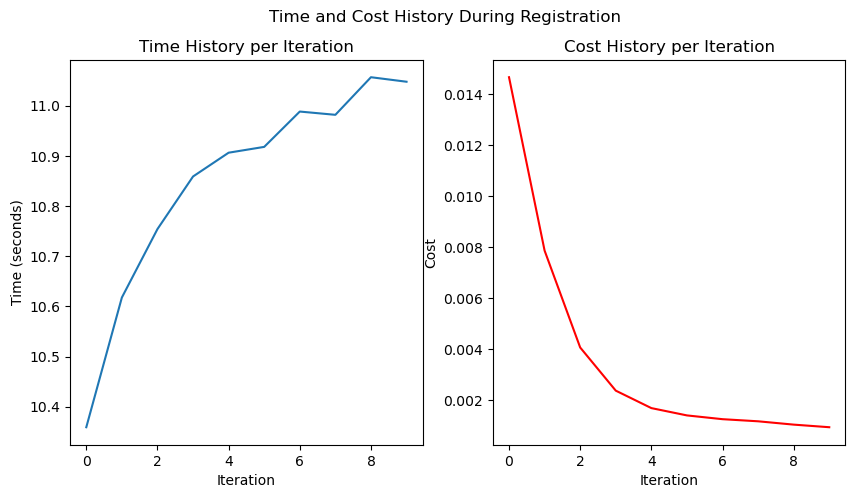

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(time_history)
plt.title('Time History per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.subplot(1, 2, 2)
plt.plot(cost_history, '-r')
plt.title('Cost History per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost')

plt.suptitle('Time and Cost History During Registration')
plt.show()